In [1]:
import pandas as pd ### para manejo de datos
import sqlite3 as sql
import a_funciones as funciones  ###archivo de funciones propias
import numpy as np
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables 
import openpyxl
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.ensemble import RandomForestClassifier  # Clasificador bosques aleatoriost 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler ## escalar variable
from sklearn.ensemble import GradientBoostingClassifier 

In [2]:
df4 = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/df_fin.csv", sep=",")
df0 = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/base16.csv", sep=",")

In [3]:
# Eliminar la variable 'resignationReason'
df4 = df4.drop('resignationReason', axis=1)
df4.head(3)


,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,JobInvolvement,PerformanceRating,Attrition
0,3,4,2,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,...,Married,131160,1,11,0,1,6,3,3,No
1,3,2,4,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,...,Single,41890,0,23,1,6,3,2,4,Yes
2,2,2,1,32,Travel_Frequently,Research & Development,17,4,Other,Male,...,Married,193280,1,15,3,5,2,3,3,No


## **Obtener dummies**

In [4]:
### generamos copia del df 
columnas = df4.columns
list_cat = [col for col in columnas if df4[col].dtype == 'object']
print(list_cat)
##list_cat = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'resignationReason']

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Attrition']


In [5]:
####Conversion a categoricas a dummies
list_dummies = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [6]:
df = pd.get_dummies(df4, columns=list_dummies)

In [7]:
####Convertimos nuestra VO a binaria 
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1}).astype(int)

In [8]:
#####Separamos nuestra variable de las demas variables
y=df.Attrition
X1= df.loc[:,~df.columns.isin(['Attrition'])]


## **Seleccion de variables**

In [9]:
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

In [10]:
######Seleccion de modelos
### 1. Regresion logistica 
m_rl = LogisticRegression()

### 2. Random forest
m_rf = RandomForestClassifier()

### 3 Arboles de decision
m_add = DecisionTreeClassifier()

### 4 GradientBoostingClassifieraa
m_gbc = GradientBoostingClassifier()


In [11]:
####Modelos
modelos = list([m_rl, m_rf, m_add, m_gbc])

In [12]:
#####Seleccion de variables 
var_names=funciones.sel_variables(modelos,X,y,threshold="2.8*mean")
var_names.shape


(6,)

In [13]:
X2=X[var_names] ### matriz con variables seleccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4284 non-null   float64
 1   DistanceFromHome    4284 non-null   float64
 2   JobSatisfaction     4284 non-null   float64
 3   MonthlyIncome       4284 non-null   float64
 4   NumCompaniesWorked  4284 non-null   float64
 5   TotalWorkingYears   4284 non-null   float64
dtypes: float64(6)
memory usage: 200.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EnvironmentSatisfaction            4284 non-null   float64
 1   JobSatisfaction                    4284 non-null   float64
 2   WorkLifeBalance                    4284 non-null   float64
 3   Age                         

## **Selección de modelo**

In [14]:
## base con todas las variables
rmse_df = funciones.medir_modelos(modelos, "f1",X,y,4)
## base con variables seleccionadas
rmse_varsel = funciones.medir_modelos(modelos,"f1",X2,y,4)



In [17]:
rmse=pd.concat([rmse_df,rmse_varsel],axis=1)
rmse.columns=['rl', 'rf', 'add', 'm_gbc',
       'rl_Sel', 'rf_sel', 'add_sel', 'm_gbc_sel']

<Axes: >

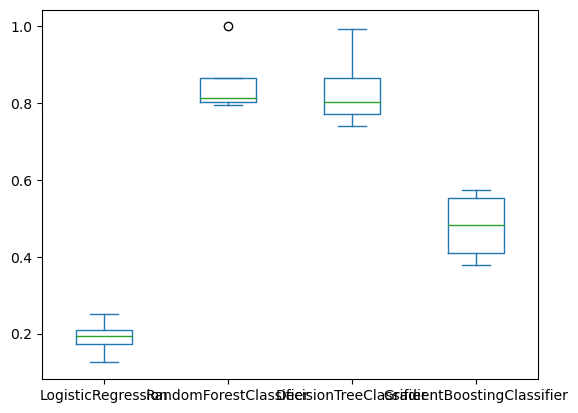

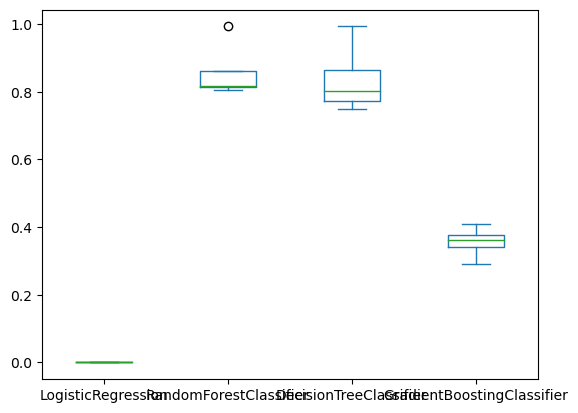

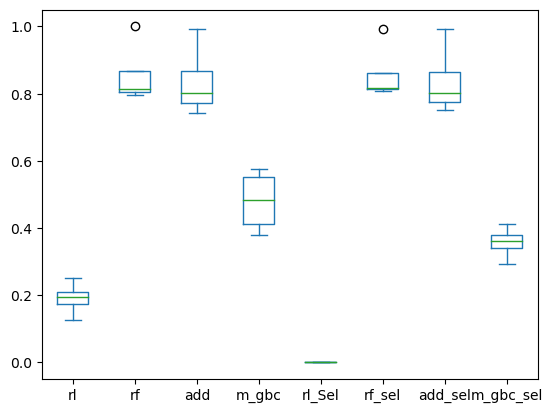

In [18]:
rmse_df.plot(kind='box') #### gráfico para modelos todas las varibles
rmse_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas
rmse.plot(kind='box') ### gráfico para modelos sel y todas las variables

rl           0.190449
rf           0.856019
add          0.835027
m_gbc        0.479575
rl_Sel       0.000000
rf_sel       0.858590
add_sel      0.836602
m_gbc_sel    0.356716
dtype: float64

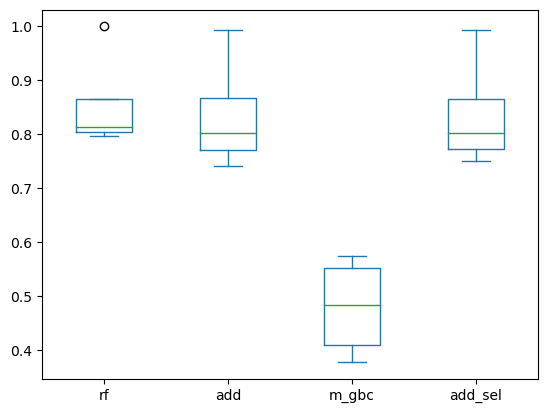

In [27]:
rmse2=rmse[['rf', 'add', 'm_gbc', 'add_sel']]
rmse2.plot(kind='box') ### gráfico para modelos sel y todas las variables
rmse.mean() ### medias de mape

In [28]:
##### Ajuste de modelo ganador; Arboles de decision se puede usar seleccionando todas o no, su resulado es casi el mismo ... en este caso vamos usar con todas las variables 
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


In [29]:
tun_add=RandomizedSearchCV(m_add,param_distributions=param_grid,n_iter=25,scoring="f1_macro")
tun_add.fit(X2, y)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=25,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='f1_macro')

In [30]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_add.cv_results_
tun_add.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
2,"{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}",0.882787
16,"{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}",0.882630
24,"{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}",0.846243
11,"{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}",0.828581
3,"{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'entropy'}",0.812103
19,"{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'entropy'}",0.809203
20,"{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}",0.792959
23,"{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}",0.791887
1,"{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}",0.766325
18,"{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}",0.764369


In [31]:
rf_final=tun_add.best_estimator_ ### Guardar el modelo con hyperparameter tunning
m_lreg=m_rf.fit(X2,y)


In [32]:
### función para exportar y guardar objetos de python (cualqueira)

joblib.dump(rf_final, "salidas\\rf_final.pkl") ## 
joblib.dump(m_lreg, "salidas\\m_lreg.pkl") ## 
joblib.dump(list_cat, "salidas\\list_cat.pkl") ### para realizar imputacion
joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "salidas\\var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "salidas\\scaler.pkl") ## 

FileNotFoundError: [Errno 2] No such file or directory: 'salidas\\rf_final.pkl'

In [ ]:
### funcion para cargar objeto guardado ###
rf_final = joblib.load("salidas\\rf_final.pkl")
m_lreg = joblib.load("salidas\\m_lreg.pkl")
list_cat=joblib.load("salidas\\list_cat.pkl")
list_dummies=joblib.load("salidas\\list_dummies.pkl")
var_names=joblib.load("salidas\\var_names.pkl")
scaler=joblib.load("salidas\\scaler.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'salidas\\rf_final.pkl'

In [ ]:

#####Evaluar métrica de entrenamiento y evaluación para mirar sobre ajuste ####
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
eval=cross_validate(rf_final,X2,y,cv=5,scoring="f1",return_train_score=True)

In [ ]:
train_rf=pd.DataFrame(eval['train_score'])
test_rf=pd.DataFrame(eval['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']
train_test_rf
train_test_rf["test_score"].mean()

1.0